<a href="https://colab.research.google.com/github/victorsergio/GNN-trajectory-prediction-2023/blob/main/sac_cluster_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This script, create clusters of a defined area, for the intesection dataset.
# For clustering this script uses the diameter-clustering lib from https://github.com/antklen/diameter-clustering

In [ ]:
!pip install similaritymeasures
!pip install diameter-clustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 KB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for similaritymeasures: filename=similaritymeasures-0.7.0-py3-none-any.whl size=15453 sha256=ca2f8f90a331ec78b64b4eaffabef6b4b4db74aeb3f16a2aec1c023f1ab2acc8
  Stored in directory: /root/.cache/pip/wheels/15/9b/33/e21656ebf649d9ec5debb9914bf5928994cd1a10de01956901
Successfully built similaritymeasures
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diameter-clustering: filename=diameter_clustering-0.1.0-py3-none-any.whl size=15680 sha256=06cf73a19dcc0fda7520831caf1af84b17b81843c5826f1e63fc81ad349a6940
  Stored 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import similaritymeasures
from diameter_clustering import LeaderClustering
from diameter_clustering import MaxDiameterClustering

import math

In [ ]:


def read_data_from_file(file_name, split=1):
    
    train_file = file_name
    df = pd.read_csv(train_file, sep=',')

    # Select a percentage from full dataset (used in debugging)
    df = df.head(math.floor(df.shape[0]*split))


    return df


def filter_data(df):
    
    # Select cars only
    df = df.loc[df['agent_type'] == "car"]
    return df

def filter_length(df):            
     
    # Select only trajectories with the same length=40 and in the same time phase
 
    g = df.groupby(["case_id", "track_id"])
 
    g_equal_len = g.filter(lambda x: x['frame_id'].count() == 40. and (x['timestamp_ms'].ge(100).any() and x['timestamp_ms'].le(4000).any()))

    return g_equal_len


def compute_distance_matrix(trajectories):
    
    n = len(trajectories)
    dist_m = np.zeros((n, n))

    for i in range(n - 1):
        p = trajectories[i]
        p = p[:, [5, 6]]     # Use only x,y columns
        p = np.array(p, dtype=float)

        for j in range(i + 1, n):
            q = trajectories[j]
            q = q[:, [5, 6]] # Use only x,y columns
            q = np.array(q, dtype=float)

            dist_m[i, j] = similaritymeasures.frechet_dist(p, q)
            dist_m[j, i] = dist_m[i, j]
    return dist_m

def max_clustering(distance_matrix, max_radius):
    
    cl = MaxDiameterClustering(max_distance=max_radius,precomputed_dist=True, deterministic=True, sparse_dist=False)
    
    labels = cl.fit_predict(distance_matrix)  
    
    return labels

def show_seq_lengths(df):
  
    # Show the average length of sequences (40 frames)
    trajectories_len = []
    groups = df.groupby(["case_id", "track_id"])

    for name, group in groups:
        trajectories_len.append(len(group))

    sns.histplot(data=trajectories_len)

def cluster_trajectories(df, max_radius, sub_sampling=False):
    
    # Convert pandas dataframe to nested list 

    all_cases = []   #  Multi-dimensional list: ( n_cases, n_tracks, n_steps, n_features)

    case_groups = df.groupby(["case_id"])

    for name, group in case_groups:

        case_tracks = []

        tracks = group.groupby(["track_id"])
    
        for ix,seq in tracks:

            sub_seq = seq.to_numpy()
            # Code here for sub-sampling 5Hz
            if (sub_sampling == True):
                sub_seq = sub_seq[0::2,:]

            case_tracks.append(sub_seq)

        all_cases.append(case_tracks)

    
    clustered_trajectories = []

    # Group trajectories calculating distance matrix and using leader clustering

    for case_n in all_cases:

        distance_matrix = compute_distance_matrix(case_n)
        labels = max_clustering(distance_matrix, max_radius=max_radius)
    

        for index, traj in enumerate(case_n):

            label_column = np.full((case_n[index].shape[0]), labels[index])
               
            trajectory = np.insert(traj, case_n[index].shape[1], label_column, axis=1)  # Insert label column at last position
            clustered_trajectories.append(trajectory)

    return clustered_trajectories

def create_clustered_dataset(df, max_radius,split):  

    # Apply clustering to select only near cars
    clustering_result = np.array(cluster_trajectories(df,max_radius=max_radius,sub_sampling=True)) #50 mts
    clustering_result = clustering_result.reshape(-1,13) # Remove the dimension added by grouping by case. 13 is the number of features

    # Save results to new dataset file
    column_names = ['case_id', 'track_id', 'frame_id', 'timestamp_ms', 'agent_type', 'x','y', 'vx', 'vy', 'psi_rad', 'length', 'width','label']
    clustered_df = pd.DataFrame(clustering_result,columns= column_names)    
    clustered_df.to_csv('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/'+str(max_radius)+'m-DR_USA_Intersection_MA_'+split+'.csv',  index = False)

    return clustered_df
    


In [ ]:
# Read full dataset
df = read_data_from_file('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/DR_USA_Intersection_MA_train.csv', split=1.0)

In [ ]:
# Select only vehicles
df = filter_data(df)

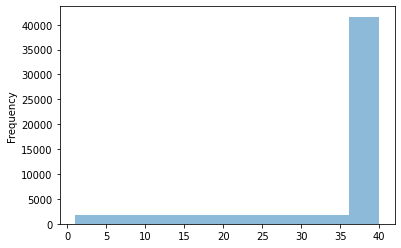

In [ ]:
# Show sequences' length
g = df.groupby(["case_id", "track_id"])
c = g.count()
column = c.frame_id
ax = column.plot.hist(bins=10, alpha=0.5)

# Select only same length sequences
df = filter_length(df)


# Full dataset info:
# 5163 episodes (cases)
# 60293 trajectories
# 2034258 rows
# 2 agent types

# Only cars dataset:

# 5163 episodes (cases)
# 58191 trajectories
# 1968886 rows
# 1 agent type

# length filtered dataset:
# 5163 episodes
# 40228 trajectories
# 1609120 rows
# 1 agent type

###############################


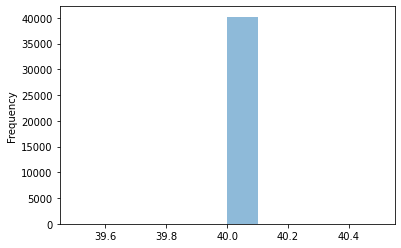

In [ ]:
# Show sequences' length
g = df.groupby(["case_id", "track_id"])
c = g.count()
column = c.frame_id
ax = column.plot.hist(bins=10, alpha=0.5)


In [ ]:
# Group counts, trajectory lengths
print(c)

                  frame_id  timestamp_ms  agent_type   x   y  vx  vy  psi_rad  \
case_id track_id                                                                
1.0     1               40            40          40  40  40  40  40       40   
        2               40            40          40  40  40  40  40       40   
        4               40            40          40  40  40  40  40       40   
        5               40            40          40  40  40  40  40       40   
        6               40            40          40  40  40  40  40       40   
...                    ...           ...         ...  ..  ..  ..  ..      ...   
5162.0  6               40            40          40  40  40  40  40       40   
5163.0  2               40            40          40  40  40  40  40       40   
        3               40            40          40  40  40  40  40       40   
        4               40            40          40  40  40  40  40       40   
        5               40  

In [ ]:
print("Only same length trajectories:", len(c))

Only same length trajectories: 40228


In [ ]:
# Split in training and test set

from numpy.random import default_rng
import math


g = df.groupby(["case_id"])
g_count = g.ngroups

training_size = math.floor(g_count/100)*80 # 80% for the training size
test_size = g_count - training_size

rng = default_rng(1)
choice = rng.choice(g.ngroups, training_size, replace=False)

# Create the two data splits
training = df[g.ngroup().isin(choice)]
test = df[~g.ngroup().isin(choice)]


In [ ]:
print("Full dataset size: ",g_count)

g = training.groupby(["case_id"])
g_count = g.ngroups
print("Training size:", g_count)

g = test.groupby(["case_id"])
g_count = g.ngroups
print("Test size:", g_count)

Full dataset size:  5163
Training size: 4080
Test size: 1083


In [ ]:
from time import process_time

# Create clustered dataset for training
start = process_time()
clustered_training = create_clustered_dataset(training, max_radius=50,split="train")
elapsed = (process_time() - start)


In [ ]:
print(elapsed)

190.10382052100002


In [ ]:
# Create clustered dataset for test
start = process_time()
clustered_test = create_clustered_dataset(test, max_radius=50,split="test")
elapsed = (process_time() - start)


In [ ]:
print(elapsed)

46.981192668999995


In [ ]:
# Load already pre-computed clustered dataset (TRAIN)
clustered_df = pd.read_csv('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/50m-DR_USA_Intersection_MA_train.csv', sep=',')


In [ ]:
# Show number of trajectories length
g = clustered_df.groupby(["case_id", "track_id"])
c = g.count()
print("Number of trajectories in train: ",c.shape[0])

Number of trajectories in train:  31778


max number of cars by cluster:  14
number of clusters: 8725


[Text(0, 0.5, 'number of groups'),
 Text(0.5, 0, 'number of interacting vehicles')]

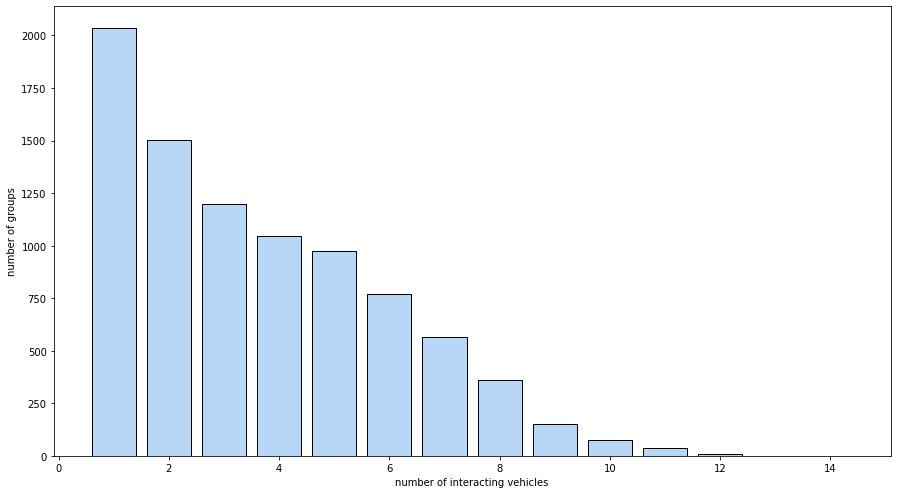

In [ ]:
# display parameters
a4_dims = (15, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.set_palette("pastel")


# Display how many clusters were created, and its elements
case_id = clustered_df.groupby(["case_id", "label"])

g = []

for ix,element in case_id:
    l = element.groupby(["track_id"])
    g.append(len(l))

print("max number of cars by cluster: ", max(g))
print("number of clusters:", len(g)) 

ax = sns.histplot(ax=ax, data=g, discrete=True, shrink=.8)
ax.set(xlabel='number of interacting vehicles', ylabel='number of groups')

In [ ]:
# Load already pre-computed clustered dataset (TEST)
clustered_df = pd.read_csv('/content/drive/MyDrive/PHD_2022/SAC/data/INTERACTION-Dataset-DR-single-v1_2/train/50m-DR_USA_Intersection_MA_test.csv', sep=',')


In [ ]:
# Show number of trajectories length
g = clustered_df.groupby(["case_id", "track_id"])
c = g.count()
print("Number of trajectories in test: ",c.shape[0])

Number of trajectories in test:  8450


max number of cars by cluster:  13
number of clusters: 2349


[Text(0, 0.5, 'number of groups'),
 Text(0.5, 0, 'number of interacting vehicles')]

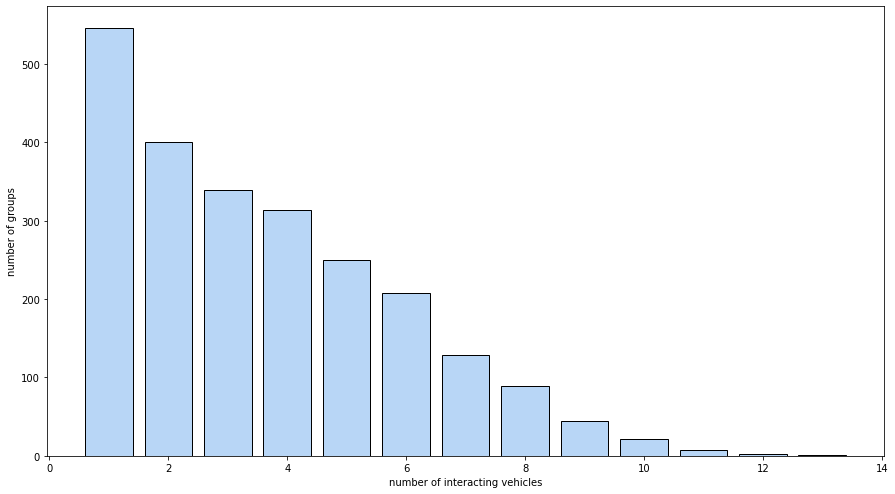

In [ ]:
# display parameters
a4_dims = (15, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.set_palette("pastel")


# Display how many clusters were created, and its elements
case_id = clustered_df.groupby(["case_id", "label"])

g = []

for ix,element in case_id:
    l = element.groupby(["track_id"])
    g.append(len(l))

print("max number of cars by cluster: ", max(g))
print("number of clusters:", len(g)) 
    
ax = sns.histplot(ax=ax, data=g, discrete=True, shrink=.8)
ax.set(xlabel='number of interacting vehicles', ylabel='number of groups')